# <center> TP 3 : Apprentissage d'un mélange - Algorithme EM

## Chargement des données MNIST

In [1]:
%pylab
%matplotlib inline 

from mnist import load_mnist
import numpy as np
import visualize as vz

train_data, train_labels = load_mnist(dataset='training', path='./')
test_data, test_labels = load_mnist(dataset='testing', path='./')

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


Transformation de `train_data` et `test_data` en vecteur colonne pour chaque exemple.

In [2]:
train_data = np.reshape(train_data, (60000, 28 * 28)).T
test_data  = np.reshape(test_data,  (10000, 28 * 28)).T

Binarisation des données :

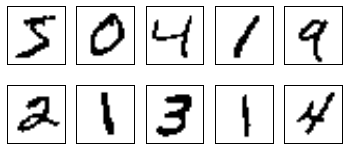

In [3]:
binarize = lambda x : x < 128 / 255
vfunc = np.vectorize(binarize)
train_data = vfunc(train_data)
test_data = vfunc(test_data)

vz.plotGroupImages(train_data[:, :10])

## Partie 1 : Théorie

A partir de ce qui a été vu en cours, déduire les étapes de l'algorithme EM pour l'apprentissage des paramètres d'un mélange de loi de Bernoulli. Donner les formules de mise à jour des différents paramètres du modèle.

L'algorithme EM fonctionne suivant deux étapes :
* L'étape appelé "expectation", qui consiste à calculer tous les poids de tous les points pour toutes les classes.
* L'étape appelé "minimization", qui vise à recalculer les moyennes pour chaque classe, en modifiant les poids de chaque classe

On pose N correspondant aux nombres d'éléments dans le dataset, K correspondant aux nombres de classes souhaitées,
$w_i$ le poid associé à la i-ème classe

**Etape 1 : Initialisation des paramètres**

* Initialisation des moyennes de chaque classe
* Initialisation des poids, tels que $\sum_1^N{w_i} = 1$

**Etape 2 : Expectation**

* Nous savons que $L(\mu | x_i) = P(x_i | \mu_k)$ et $P(x_i | \mu) = \mu ^ x_i (1 − p) ^ n − x_i$ en utilisant une distribution de Bernouilli
* Nous savons aussi que 

## Partie 2 : Implémentation

On vous demandera de tester différentes valeurs pour le nombre de composantes du mélange ainsi que différentes initialisations du modèle.

**1.** Implémenter cet algorithme et faire l'apprentissage sur les données binaires TRAINB obtenues précedemment. Attention à la manipulation des valeurs de probabilités (entre 0 et 1) qui deviennet rapidement nulles à cause de la précision des chiffres flottants).

In [4]:
# TODO
from EmBernoulli import *

emb = EmBernoulli()
W, center = emb.computeEM(test_data, 10)
#print(W)
#print(center)

10000


**2.** Afficher les moyennes des différentes distributions de Bernoulli ?

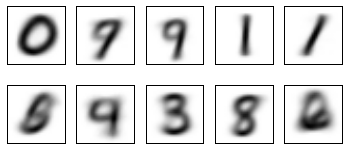

In [5]:
vz.plotGroupImages(center)

**3.** En utilisant uniquement 10 composantes, est-il possible d'avoir un centre par classe ? Justifier.

In [6]:
# TODO

**4.** Tester un classifieur bayésien en utilisant un mélange pour chaque classe ? Quel est le taux de reconnaissance obtenu (tester 1, 2, 4, et 8 composantes par classe) ?

In [7]:
# TODO

## Partie 3 : Comparaison avec un GMM

Comparer les résultats obtenus avec le cas d'un mélange de gaussiennes sur les données brutes TRAIN et TEST.

**1.** Envisager le cas de gaussienne avec des matrices de covariance diagonale, ensuite tester la version avec matrices de covariance complètes.

In [8]:
# TODO

**2.** Attention à la dégénérescence de l'algorithme EM (matrice de covariance non inversible). Il faut voir comment gérer ce problème ainsi que l'initialisation.

In [9]:
# TODO

**3.** Proposer la meilleure solution pour avoir le plus haut taux de reconnaissance.

In [10]:
# TODO